In [188]:
import theseus as th
from planner import MotionPlannerObjective
import torch
import numpy as np
import matplotlib.pyplot as plt

dtype = torch.double
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [189]:
CURRENT_STATE = torch.tensor((1.3, 0, 0))  # x, y, theta
GOAL_POSITION = torch.tensor((1.5, 2.95))  # x, y
CELL_SIZE = 0.05
SDF_ORIGIN = (0, 0)


In [190]:

objective = MotionPlannerObjective(
    total_time=60.0,
    horizon=30,
    current_velocity=torch.tensor([0.0, 0.0], dtype=dtype),
    x_velocity_bounds=torch.tensor([-5, 5], dtype=dtype),
    y_velocity_bounds=torch.tensor([-5, 5], dtype=dtype),
    x_acceleration_bounds=torch.tensor([-5, 5], dtype=dtype),
    y_acceleration_bounds=torch.tensor([-5, 5], dtype=dtype),
    robot_radius=0.5,  # REPLACE WITH ACTUAL RADIUS
    safety_distance=0.1,  # REPLACE WITH ACTUAL SAFETY DISTANCE
    local_map_size=60,  # REPLACE WITH ACTUAL MAP SIZE
)

optimizer = th.LevenbergMarquardt(
    objective,
    th.CholeskyDenseSolver,
    max_iterations=50,
    step_size=1.0,
)
motion_planner = th.TheseusLayer(optimizer)
motion_planner.to(device, dtype=torch.double)


TheseusLayer()

In [191]:
def get_straight_line_inputs(start: torch.Tensor, goal: torch.Tensor, total_time, horizon):
    # Returns a dictionary with state and acceleration variable names associated to a
    # straight line trajectory between start and goal in SE(2) space

    # Calculate start and goal positions
    start_pos = start[..., :2]  # Extracting the 2D position from SE(2)
    goal_pos = goal  # Assuming goal is already a 2D point

    # Calculate distances and average accelerations for each batch element
    start_goal_dist = goal_pos - start_pos  # Shape: (batch_size, 2)
    avg_acc = 2 * start_goal_dist / (total_time**2)  # Shape: (batch_size, 2)
    unit_horizon = start_goal_dist / (horizon - 1)  # Shape: (batch_size, 2)

    # Create input dictionary
    input_dict = {}

    for i in range(horizon + 1):
        state_i = start_pos + unit_horizon * i  # Shape: (batch_size, 2)
        # Concatenate the 2D position with the orientation
        input_dict[f"state_{i}"] = torch.concat(
            [state_i, start[..., 2:]], dim=-1)

        if i == horizon:
            continue

        if i == 0 or i == horizon - 1:
            # Zero acceleration at start and end
            acceleration_i = torch.zeros_like(avg_acc)
        else:
            acceleration_i = avg_acc

        input_dict[f"acceleration_{i}"] = acceleration_i

    return input_dict


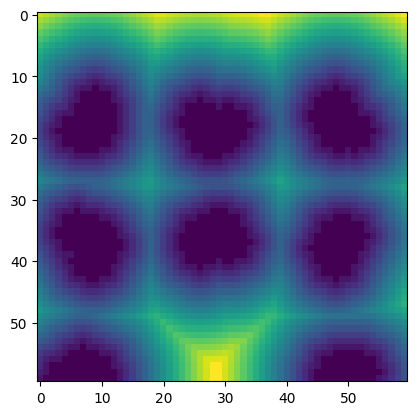

In [192]:

file_path = "sdf_array.npy"
sdf = torch.tensor(np.load(file_path), dtype=dtype)
plt.imshow(sdf)


In [193]:
planner_inputs = {
    # REPLACE WITH SDF DATA
    'sdf_data': sdf.unsqueeze(0).to(device),
    'sdf_origin': torch.tensor([SDF_ORIGIN[0], SDF_ORIGIN[1]], dtype=dtype).unsqueeze(0).to(device),
    'cell_size': torch.tensor([CELL_SIZE], dtype=dtype).unsqueeze(0).to(device),
    'current_state': torch.tensor([CURRENT_STATE[0], CURRENT_STATE[1], torch.cos(CURRENT_STATE[2]), torch.sin(CURRENT_STATE[2])], dtype=dtype).unsqueeze(0).to(device),
    'goal_position': torch.tensor([GOAL_POSITION[0], GOAL_POSITION[1]], dtype=dtype).unsqueeze(0).to(device),
}
planner_inputs.update(get_straight_line_inputs(
    planner_inputs['current_state'], planner_inputs['goal_position'], 60.0, 30))


In [194]:
with torch.no_grad():
    final_values, info = motion_planner.forward(
        planner_inputs,
        optimizer_kwargs={
            "track_best_solution": True,
            "verbose": True,
            "damping": 0.1,
        }
    )

solution_dictionary = info.best_solution


Nonlinear optimizer. Iteration: 0. Error: 1318378.0384037374
Nonlinear optimizer. Iteration: 1. Error: 1791810.4397499082
Nonlinear optimizer. Iteration: 2. Error: 1350806.40453539
Nonlinear optimizer. Iteration: 3. Error: 1350806.3984678523


In [195]:
print(solution_dictionary)


{'state_1': tensor([[1.3069, 0.1017, 1.0000, 0.0000]], dtype=torch.float64), 'state_2': tensor([[1.3138, 0.2034, 1.0000, 0.0000]], dtype=torch.float64), 'state_3': tensor([[1.3207, 0.3052, 1.0000, 0.0000]], dtype=torch.float64), 'state_4': tensor([[1.3276, 0.4069, 1.0000, 0.0000]], dtype=torch.float64), 'state_5': tensor([[1.3345, 0.5086, 1.0000, 0.0000]], dtype=torch.float64), 'state_6': tensor([[1.3414, 0.6103, 1.0000, 0.0000]], dtype=torch.float64), 'state_7': tensor([[1.3483, 0.7121, 1.0000, 0.0000]], dtype=torch.float64), 'state_8': tensor([[1.3552, 0.8138, 1.0000, 0.0000]], dtype=torch.float64), 'state_9': tensor([[1.3621, 0.9155, 1.0000, 0.0000]], dtype=torch.float64), 'state_10': tensor([[1.3690, 1.0172, 1.0000, 0.0000]], dtype=torch.float64), 'state_11': tensor([[1.3759, 1.1190, 1.0000, 0.0000]], dtype=torch.float64), 'state_12': tensor([[1.3828, 1.2207, 1.0000, 0.0000]], dtype=torch.float64), 'state_13': tensor([[1.3897, 1.3224, 1.0000, 0.0000]], dtype=torch.float64), 'state_

In [196]:
state_values = {key: value for key,
                value in solution_dictionary.items() if 'state' in key}
trajectory = torch.stack(list(state_values.values()), dim=0)


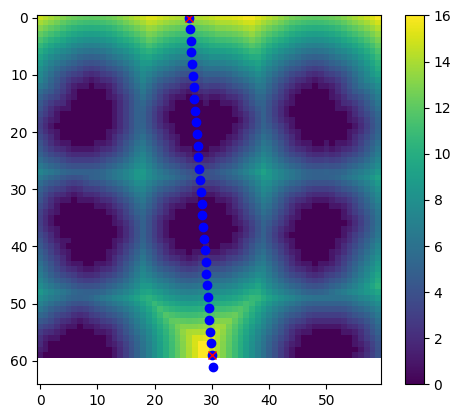

In [197]:

plt.imshow(sdf)
for x, y, a, b in trajectory.squeeze():
    plt.plot(x/CELL_SIZE, y/CELL_SIZE, 'bo')

plt.plot(CURRENT_STATE[0]/CELL_SIZE, CURRENT_STATE[1]/CELL_SIZE, 'rx')
plt.plot(GOAL_POSITION[0]/CELL_SIZE, GOAL_POSITION[1]/CELL_SIZE, 'rx')
plt.colorbar()
plt.show()
